In [1]:
# experiment.ipynb
# setting up
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import numpy as np

In this notebook, we'll aim to make it possible to run the Mesa version of the ElectricityMarket model, but to then get outputs matching those in the source notebook.

So, to outline:

0. Get the model ready by feeding in params from our source notebook.
1. Run the model (with any quality of life paramaterization inputs) from the first cell.
2. Take the model outputs (which also could be accessed through the Mesa framework)
3. Convert the mesa outputs to the vectors from the source notebook.
4. Plot just as before.

We will structure *this* notebook to mirror the source as best we can. ⚡️

In [2]:
from mesa import Model # noqa
from model import ElectricityMarket # noqa

Okay! Mesa! Before we get rolling with parameters, let's talk about what we're going to do with the logic from the original notebook. To understand the plan, it's important to know about the Mesa Framework that it supplies a couple of key basic tools we can use: the [Model](https://mesa.readthedocs.io/latest/apis/model.html#module-mesa.model) class, and the [Agent](https://mesa.readthedocs.io/latest/apis/agent.html) class. The model is where we'll need to register and step through many of the equations of the notebook, while the agent objects will take the basic decisioning logic that executes each step.

In the following code cell, we have a *synopsis* of the major functions from the model code in the `ElectricityAuctions` notebook. Uncommenting the cell may interfere with running this notebook.

In [3]:
pass

"""The logic from this block can ALL be found in the `model.py` file..

define functions
def find_capacities(prices, m, b):
    return m * prices + b

def create_expectations(n, capacities, costs):
    # logic here
    return(capacity_expectations, cost_expectations, expected_rankings)
    
def auction(N, bids, capacities):
    # complicated logic here
    return(quantities, last_price)

def outcomes(mechanism, last_price, bids, quantities, costs):
    if mechanism == 'uniform':
        revenues = last_price * quantities  
    else:
        revenues = bids * quantities
    profits = revenues - costs * quantities
    return(revenues, profits)

## The logic from this block can ALL be found in the `agents.py` file.

def generate_bids(n, N, mechanism, capacity_expectations, cost_expectations, expected_rankings, padding, costs):
    bids = np.empty(n)
    for g in range(n):    
       # complicated logic here
    return(bids)

###########################

## and then we have these critical equations:
costs = rng.uniform(min_cost, max_cost, n)
capacities = find_capacities(costs, m, b)
price_cap = max(costs) * cap_multiplier
errors = (rng.uniform(min_error, max_error, n*n) / 100 * np.random.choice([-1,1],size=n*n)).reshape([n,n])
padding = rng.uniform(min_padding, max_padding, n) / 100
capacity_expectations, cost_expectations, expected_rankings = create_expectations(n, capacities, costs)

these are in the `model.py` file.


"""


"The logic from this block can ALL be found in the `model.py` file..\n\ndefine functions\ndef find_capacities(prices, m, b):\n    return m * prices + b\n\ndef create_expectations(n, capacities, costs):\n    # logic here\n    return(capacity_expectations, cost_expectations, expected_rankings)\n    \ndef auction(N, bids, capacities):\n    # complicated logic here\n    return(quantities, last_price)\n\ndef outcomes(mechanism, last_price, bids, quantities, costs):\n    if mechanism == 'uniform':\n        revenues = last_price * quantities  \n    else:\n        revenues = bids * quantities\n    profits = revenues - costs * quantities\n    return(revenues, profits)\n\n## The logic from this block can ALL be found in the `agents.py` file.\n\ndef generate_bids(n, N, mechanism, capacity_expectations, cost_expectations, expected_rankings, padding, costs):\n    bids = np.empty(n)\n    for g in range(n):    \n       # complicated logic here\n    return(bids)\n\n###########################\n\n## an

One important point: there is overlap between how the code from the source notebook executes and the standard functions of the Mesa model and agents objects. Wherever practical, we will stick to using the functionality provided in the source. One key difference is that our time and step-running logic will be delegated to Mesa fundamental functions.

⚡️

Let's first get ready by setting up a set of parameters to pass our Mesa Model. The Mesa Model object, among other things, natively takes keyword-arguments (or kwargs) at initialization time. But, of course, it can also have defaults. This means that we can set some parameters or all parameters in the cell below, and they will be passed to the underlying Mesa engine.

Once we're done readying parameters, we can run the cell. `ElectricityMarket.run` will pass the parameters to the model in `model.py`, and it will run its steps. 1000 steps can take a few seconds!

In [4]:
# set parameters
n = 5
m = -5
b = 1000
steps = 1000
min_cost = 20
max_cost = 200
min_error = 1
max_error = 20
min_padding = 50
max_padding = 99
cap_multiplier = 1.2

params = {
    'n': n,
    'm': m,
    'b': b,
    'steps': steps,
    'min_cost': min_cost,
    'max_cost': max_cost,
    'min_error': min_error,
    'max_error': max_error,
    'min_padding': min_padding,
    'max_padding': max_padding,
    'cap_multiplier': cap_multiplier
}

model = ElectricityMarket(**params) # this is our Mesa Model! We'll run it in a sec.

# or, you can run the model with one param:
# steps = 88888
# model = ElectricityMarket.run(steps=steps)

# or, you can just run the model with the defaults:
# returns = ElectricityMarket.run()

Okay, our model is set up. We are almost ready to run... but first, to integrate with the rest of the Mesa setup, we will replace this approach
from the source model:

```py
mechanism = 'uniform'
#mechanism = 'discriminatory'
#mechanism = 'ownbid'
```

... with an array that allows us to run the model once for each mechanism:

In [5]:
mechanisms = ['uniform', 'discriminatory', 'ownbid']

# note that steps and agents(n) are defined... but they may have been commented out above. 
# let's make sure we have them
steps = steps if 'steps' in locals() else 1000
n = n if 'n' in locals() else 5

# the following code is almost straight from the source notebook,
# but we modify it to work with each mechanism in the array.
# # initialise arrays to store simulation results for each time step.
RTO_costs_by_mechanism = {mechanism: np.empty(steps) for mechanism in mechanisms} # note that steps
GenCo_profits_by_mechanism = {mechanism: np.empty([steps,n]) for mechanism in mechanisms} # and number of agents are defined in params

Okay, great. Now we are ready to run the model. The original code block for running the model from the notebook looks like:

```py
# for timesteps specified by steps, run a series of auctions. 
# each time step the RTO request varies.
for s in range(steps): 
    N = rng.uniform(int(np.mean(capacities)), int(np.sum(capacities)))
    bids = generate_bids(n, N, mechanism, capacity_expectations, cost_expectations, expected_rankings, padding, costs)
    quantities, last_price = auction(N, bids, capacities)
    revenues, profits = outcomes(mechanism, last_price, bids, quantities, costs)
    RTO_costs[s] = sum(revenues)
    GenCo_profits[s] = profits
```

This logic will go into the `model.py` code's `_run_model()_` method of the `ElectricityMarket` class extending the Mesa `Model`.
So, we need only run the model, although we will wrap it in a loop so that we can get returns for each of our mechanisms.

In [6]:
# the definition for our ElectricityMarket model specifies a return of:
# {
#     'RTO_costs': Array of RTO costs for each step
#     'GenCo_profits': 2D array of profits for each GenCo at each step
#     'mechanism': Mechanism used for this run
#     'agent_outcomes': List of outcomes for each agent, including step, revenue, profit, and whether they won the auction
# }

outcomes_by_mechanism = {}

for mechanism in mechanisms:
    model.mechanism = mechanism
    results = model.run_model(mechanism)

    # now we can move those results into our vectors, very similarly to the source notebook.

    RTO_costs_by_mechanism[mechanism] = results['RTO_costs']
    GenCo_profits_by_mechanism[mechanism] = results['GenCo_profits']

    # and we might like to make a gesture to our audience:
    print(f"Mechanism {mechanism} complete.")
    print(f"Mean RTO cost: {round(np.mean(RTO_costs_by_mechanism[mechanism]), 2)}")
    print(f"Mean GenCo profit: {round(np.mean(np.sum(GenCo_profits_by_mechanism[mechanism], axis=1)), 2)}")

    # let's also save the agent outcomes for each mechanism
    outcomes_by_mechanism[mechanism] = results['agent_outcomes']

    # create a fresh model instance for the next mechanism
    model = ElectricityMarket(**params)



Time: 0
Time: 100
Time: 200
Time: 300
Time: 400
Time: 500
Time: 600
Time: 700
Time: 800
Time: 900
Mechanism uniform complete.
Mean RTO cost: 236782.11
Mean GenCo profit: 141227.79
Time: 0
Time: 100
Time: 200
Time: 300
Time: 400
Time: 500
Time: 600
Time: 700
Time: 800
Time: 900
Mechanism discriminatory complete.
Mean RTO cost: 228645.12
Mean GenCo profit: 108157.51
Time: 0
Time: 100
Time: 200
Time: 300
Time: 400
Time: 500
Time: 600
Time: 700
Time: 800
Time: 900
Mechanism ownbid complete.
Mean RTO cost: 108028.5
Mean GenCo profit: 0.0


Hopefully, that printed a nice list of pretty statistics. Now, looking back at our agenda, we are more or less through the entire stage of setting up
our vectors. We are almost ready to plot.

⚡️

And now let's go ahead and build out plots, with just a subtle tweak. Since we have all three mechanisms ready to go, we should be able to shuffle between them in our plot viewer. We just need to do a little organizing up front...

In [7]:
selected_mechanism_one = 'uniform'
selected_mechanism_two = 'discriminatory'

plot_output = widgets.Output()

def update_plots(selected_mechanism_one, selected_mechanism_two):
    display_mechanism_one = selected_mechanism_one
    display_mechanism_two = selected_mechanism_two

    mean_cost_mechanism_one = np.mean(RTO_costs_by_mechanism[display_mechanism_one])
    mean_cost_mechanism_two = np.mean(RTO_costs_by_mechanism[display_mechanism_two])

    mean_profit_mechanism_one = np.mean(np.sum(GenCo_profits_by_mechanism[display_mechanism_one], axis=1))
    mean_profit_mechanism_two = np.mean(np.sum(GenCo_profits_by_mechanism[display_mechanism_two], axis=1))

    # plot profit and cost values for the various auction price mechanisms
    with plot_output:
        clear_output(wait=True)
        fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 6))

        ax[0].plot(range(steps), np.cumsum(np.sum(GenCo_profits_by_mechanism[display_mechanism_one], axis=1)) / np.arange(1, steps + 1), c = 'darkred', label = display_mechanism_one)
        ax[0].plot(np.cumsum(np.sum(GenCo_profits_by_mechanism[display_mechanism_two], axis=1)) / np.arange(1, steps + 1), c = 'hotpink', label = display_mechanism_two)
        ax[0].set_xlabel('steps')
        ax[0].set_ylabel('cumulative mean of GenCo profits')
        ax[0].legend(frameon = False)
        ax[1].plot(range(steps), np.cumsum(RTO_costs_by_mechanism[display_mechanism_one]) / np.arange(1, steps + 1), c = 'cadetblue', label = display_mechanism_one)
        ax[1].plot(np.cumsum(RTO_costs_by_mechanism[display_mechanism_two]) / np.arange(1, steps + 1), c = 'skyblue', label = display_mechanism_two)
        ax[1].set_xlabel('steps')
        ax[1].set_ylabel('cumulative mean of RTO costs')
        ax[1].legend(frameon = False)

        #ax[0].annotate('uniform', xy=(600, 63000))
        #ax[0].annotate('discriminatory', xy=(600, 50500))
        #ax[1].annotate('uniform', xy=(700, 160000))
        #ax[1].annotate('discriminatory', xy=(700, 148000))
        ax[1].axhline(y = mean_cost_mechanism_one, linestyle = 'dotted', c = 'grey')
        ax[1].axhline(y = mean_cost_mechanism_two, linestyle = 'dotted', c = 'grey')
        ax[0].axhline(y = mean_profit_mechanism_one, linestyle = 'dotted', c = 'grey')
        ax[0].axhline(y = mean_profit_mechanism_two, linestyle = 'dotted', c = 'grey')

        fig.suptitle('discriminatory vs uniform pricing')
        sns.despine(left = True, bottom = True)
        plt.show()

# add dropdowns
mechanism_one_dropdown = widgets.Dropdown(
    options=mechanisms,
    value=selected_mechanism_one,
    description='Mechanism 1:',
    style={'description_width': 'initial'}
)

mechanism_two_dropdown = widgets.Dropdown(
    options=mechanisms,
    value=selected_mechanism_two,
    description='Mechanism 2:',
    style={'description_width': 'initial'}
)

# Define the callback for dropdown changes
def on_mechanism_change(change):
    update_plots(
        selected_mechanism_one=mechanism_one_dropdown.value,
        selected_mechanism_two=mechanism_two_dropdown.value
    )

# Register callbacks
mechanism_one_dropdown.observe(on_mechanism_change, names='value')
mechanism_two_dropdown.observe(on_mechanism_change, names='value')

# Initial plot
update_plots(selected_mechanism_one, selected_mechanism_two)

# Show controls below plot, and shade the HBox slightly to highlight it
controls_box = widgets.HBox(
    [mechanism_one_dropdown, mechanism_two_dropdown],
    layout=widgets.Layout(
        background='blue',
        border='1px solid black',
        padding='10px'
    )
)
display(plot_output, controls_box)

Output()

And then, finally, because we have our Mesa model embedded, we now also have a record of individual agent behavior from that model. We can use that record to help us elucidate (illuminate? make clearer? something) the way in which the individual agents are operating---both in our version of the Electricity Auction, and the one from the source notebook as well.

Output()

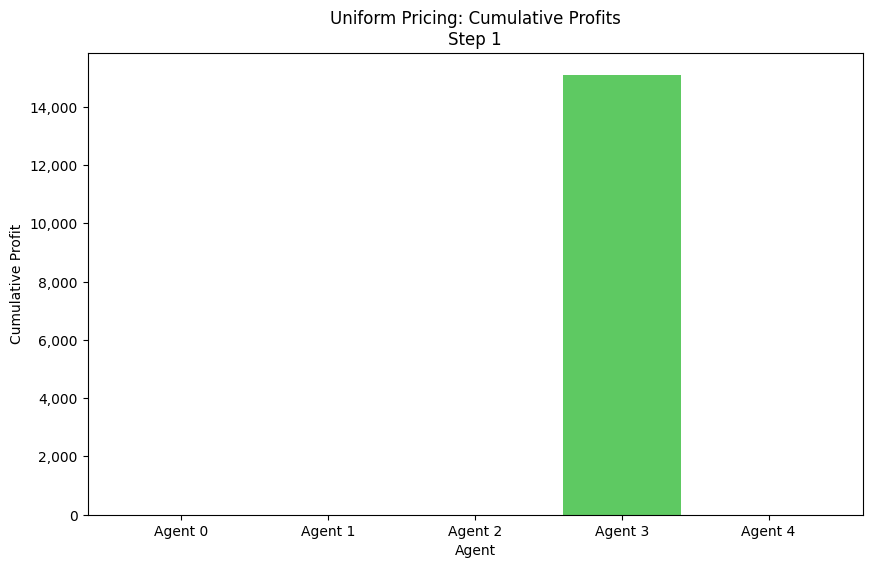

In [8]:

agent_history_output = widgets.Output()
history_mechanism_dropdown_selected = 'uniform'

def plot_agent_history(mechanism):
    """Create an animated vertical bar chart of agent profits"""
    with agent_history_output:
        clear_output(wait=True)
        
        # Create figure for animation
        fig, ax = plt.subplots(figsize=(10, 6))
        
        def update(frame):
            ax.clear()
            # For each agent, compute cumulative profit up to frame
            profits = []
            for agent_outcome in outcomes_by_mechanism[mechanism]:
                # Convert np.float64 to regular float
                cumulative_profit = float(sum(float(outcome['profit']) 
                                    for outcome in agent_outcome[:frame]))
                profits.append(cumulative_profit)
            
            # Create vertical bar chart
            colors = plt.cm.viridis(np.linspace(0, 1, len(profits)))
            ax.bar(range(len(profits)), profits, color=colors)
            
            # Customize appearance
            ax.set_xticks(range(len(profits)))
            ax.set_xticklabels([f'Agent {i}' for i in range(len(profits))])
            ax.set_xlabel('Agent')
            ax.set_ylabel('Cumulative Profit')
            ax.set_title(f'{mechanism.capitalize()} Pricing: Cumulative Profits\nStep {frame}')
            
            # Format y-axis with comma separator for thousands
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
            
            # Rotate labels for better readability if needed
            plt.xticks(rotation=0)
        
        # Ensure animation object remains in scope
        global agent_history_anim
        agent_history_anim = animation.FuncAnimation(
            fig,
            update,
            frames=range(1, steps, 10),  # update every 10 steps
            interval=100,
            repeat=False
        )
        
        # Display animation as HTML
        display(HTML(agent_history_anim.to_jshtml()))

# Create controls
history_mechanism_dropdown = widgets.Dropdown(
    options=mechanisms,
    value=history_mechanism_dropdown_selected,
    description='Mechanism:',
    style={'description_width': 'initial'}
)

history_button = widgets.Button(
    description='Show Agent History',
    button_style='info'
)

def on_history_button_click(b):
    plot_agent_history(history_mechanism_dropdown.value)

history_button.on_click(on_history_button_click)

#Auto-run with default mechanism
plot_agent_history(history_mechanism_dropdown.value)

# Display output and controls
display(agent_history_output, widgets.HBox([history_mechanism_dropdown, history_button]))